In [8]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

#Choosing which years/files to read
el_csv_files = ["Day-ahead Prices_202301010000-202401010000.csv"]
electricity_df = pd.DataFrame()
start_date = datetime(year = 2023, month = 1, day=1, hour=0, minute=0)
end_date = datetime(year=2023, month = 11, day = 3)


for filename in el_csv_files:
    process_df = pd.read_csv(filename)
    electricity_df = pd.concat([electricity_df,process_df])

electricity_df = electricity_df[electricity_df["Day-ahead Price [EUR/MWh]"] != "-"].drop(labels = "BZN|CH", axis = 1)
electricity_df[['time_start','time_stop']] = electricity_df['MTU (CET/CEST)'].str.split(' - ',expand=True)
electricity_df["time_start"] = pd.to_datetime(electricity_df["time_start"], format = "%d.%m.%Y %H:%M")
electricity_df["time_stop"] = pd.to_datetime(electricity_df["time_stop"], format = "%d.%m.%Y %H:%M")
electricity_df["Day-ahead Price [EUR/MWh]"] = pd.to_numeric(electricity_df["Day-ahead Price [EUR/MWh]"])
    

interval_size_int = 4
interval_size = pd.Timedelta(hours=interval_size_int)

electricity_df["average_electricity_price"] = pd.Series()
prices_series = pd.Series()
date_iterator = start_date
while date_iterator < end_date:
    df = electricity_df [(electricity_df["time_start"] >= date_iterator) & (electricity_df["time_start"]< date_iterator + interval_size)]
    #Finding the average 4 hour price in EUR/MWh
    avg_price = df["Day-ahead Price [EUR/MWh]"].sum()
    indices = list(df.index.values)
    electricity_df["average_electricity_price"].loc[indices[0]:indices[-1]] = avg_price 
    date_iterator = date_iterator+interval_size
electricity_df = electricity_df[electricity_df["time_start"].dt.hour%4 ==0]
electricity_df

C:\Users\ida\AppData\Local\Temp\ipykernel_6448\2453907447.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  electricity_df["average_electricity_price"].loc[indices[0]:indices[-1]] = avg_price
C:\Users\ida\AppData\Local\Temp\ipykernel_6448\2453907447.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  electricity_df["average_electricity_price"].loc[indices[0]:indices[-1]] = avg_price
C:\Users\ida\AppData\Local\Temp\ipykernel_6448\2453907447.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/sta

,MTU (CET/CEST),Day-ahead Price [EUR/MWh],Currency,time_start,time_stop,average_electricity_price
0,01.01.2023 00:00 - 01.01.2023 01:00,0.03,EUR,2023-01-01 00:00:00,2023-01-01 01:00:00,-18.92
4,01.01.2023 04:00 - 01.01.2023 05:00,-9.71,EUR,2023-01-01 04:00:00,2023-01-01 05:00:00,-39.85
8,01.01.2023 08:00 - 01.01.2023 09:00,0.02,EUR,2023-01-01 08:00:00,2023-01-01 09:00:00,-7.04
12,01.01.2023 12:00 - 01.01.2023 13:00,2.96,EUR,2023-01-01 12:00:00,2023-01-01 13:00:00,14.76
16,01.01.2023 16:00 - 01.01.2023 17:00,19.95,EUR,2023-01-01 16:00:00,2023-01-01 17:00:00,119.95
...,...,...,...,...,...,...
7325,02.11.2023 04:00 - 02.11.2023 05:00,6.80,EUR,2023-11-02 04:00:00,2023-11-02 05:00:00,180.58
7329,02.11.2023 08:00 - 02.11.2023 09:00,72.37,EUR,2023-11-02 08:00:00,2023-11-02 09:00:00,260.94
7333,02.11.2023 12:00 - 02.11.2023 13:00,57.46,EUR,2023-11-02 12:00:00,2023-11-02 13:00:00,254.87
7337,02.11.2023 16:00 - 02.11.2023 17:00,76.87,EUR,2023-11-02 16:00:00,2023-11-02 17:00:00,364.75


In [9]:
ancillary_df = pd.DataFrame()

an_csv_files = ["2023-PRL-SRL-TRL-Ergebnis.csv"]
ancillary_df = pd.DataFrame()
start_date = datetime(year = 2023, month = 1, day=1, hour=0, minute=0)
end_date = datetime(year=2023, month = 11, day = 3)

for filename in an_csv_files:
    process_df = pd.read_csv(filename, sep = ";")
    ancillary_df = pd.concat([ancillary_df,process_df])

ancillary_type = "PRL"
ancillary_df = ancillary_df[ancillary_df["Ausschreibung"].str[0:3] == ancillary_type]
display(ancillary_df)
ancillary_df = ancillary_df.apply(lambda col: pd.to_numeric(col, errors = "ignore"), axis = 1)

day = ancillary_df["Ausschreibung"].str[-8:]
time = ancillary_df["Beschreibung"].str[-len("00:00 bis 04:00"):]
time_string = day + " " + time.str[0:5]
ancillary_df["time_start"] = pd.to_datetime(time_string, format = "%y_%m_%d %H:%M")

#We see  that volume that cannot be parted is relatively small so we can look away from that in the first place
print(ancillary_df[ancillary_df["Teilbarkeit"] != "Ja"]["Angebotenes Volumen"].sum()/ancillary_df["Angebotenes Volumen"].sum())

ancillary_df["average_ancillary_price"] = pd.Series()
for time in ancillary_df["time_start"].unique():
    df = ancillary_df[ancillary_df["time_start"] == time]
    avg_price = df["Leistungspreis"].sum()/df["Angebotenes Volumen"].sum()
    indices = list(df.index.values)
    ancillary_df["average_ancillary_price"].loc[indices[0]:indices[-1]] = avg_price
ancillary_df


C:\Users\ida\AppData\Local\Temp\ipykernel_6448\2688424265.py:9: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  process_df = pd.read_csv(filename, sep = ";")


,Ausschreibung,Beschreibung,Angebotenes Volumen,Einheit,Zugesprochenes Volumen,Einheit.1,Leistungspreis,Einheit.2,Kosten,Einheit.3,Preis,Einheit.4,Land,Angebotspreis,Einheit.5,Teilbarkeit
0,PRL_23_01_01,Primary control Auction 00:00 bis 04:00,5,MW,5,MW,80.0,EUR/MW,400.0,EUR,34.82,EUR/MWh*,CH,20.00,EUR/MWh*,Ja
1,PRL_23_01_01,Primary control Auction 00:00 bis 04:00,1,MW,1,MW,54.4,EUR/MW,54.4,EUR,34.82,EUR/MWh*,CH,13.60,EUR/MWh*,Ja
2,PRL_23_01_01,Primary control Auction 00:00 bis 04:00,1,MW,1,MW,51.2,EUR/MW,51.2,EUR,34.82,EUR/MWh*,CH,12.80,EUR/MWh*,Ja
3,PRL_23_01_01,Primary control Auction 00:00 bis 04:00,1,MW,1,MW,66.1,EUR/MW,66.1,EUR,34.82,EUR/MWh*,CH,16.52,EUR/MWh*,Ja
4,PRL_23_01_01,Primary control Auction 00:00 bis 04:00,5,MW,5,MW,85.0,EUR/MW,425.0,EUR,34.82,EUR/MWh*,CH,21.25,EUR/MWh*,Ja
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
437459,PRL_23_11_04,Primary control Auction 20:00 bis 24:00,1,MW,1,MW,0.0,EUR/MW,0.0,EUR,32.11,EUR/MWh*,DE,0.00,EUR/MWh*,Ja
437460,PRL_23_11_04,Primary control Auction 20:00 bis 24:00,5,MW,5,MW,30.0,EUR/MW,150.0,EUR,32.11,EUR/MWh*,DE,7.50,EUR/MWh*,Ja
437461,PRL_23_11_04,Primary control Auction 20:00 bis 24:00,2,MW,2,MW,6.7,EUR/MW,13.4,EUR,32.11,EUR/MWh*,DE,1.68,EUR/MWh*,Ja
437462,PRL_23_11_04,Primary control Auction 20:00 bis 24:00,1,MW,1,MW,5.0,EUR/MW,5.0,EUR,32.11,EUR/MWh*,DE,1.25,EUR/MWh*,Ja


0.022584489678114418


C:\Users\ida\AppData\Local\Temp\ipykernel_6448\2688424265.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ancillary_df["average_ancillary_price"].loc[indices[0]:indices[-1]] = avg_price
C:\Users\ida\AppData\Local\Temp\ipykernel_6448\2688424265.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ancillary_df["average_ancillary_price"].loc[indices[0]:indices[-1]] = avg_price
C:\Users\ida\AppData\Local\Temp\ipykernel_6448\2688424265.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

,Ausschreibung,Beschreibung,Angebotenes Volumen,Einheit,Zugesprochenes Volumen,Einheit.1,Leistungspreis,Einheit.2,Kosten,Einheit.3,Preis,Einheit.4,Land,Angebotspreis,Einheit.5,Teilbarkeit,time_start,average_ancillary_price
0,PRL_23_01_01,Primary control Auction 00:00 bis 04:00,5,MW,5,MW,80.0,EUR/MW,400.0,EUR,34.82,EUR/MWh*,CH,20.00,EUR/MWh*,Ja,2023-01-01 00:00:00,3.871158
1,PRL_23_01_01,Primary control Auction 00:00 bis 04:00,1,MW,1,MW,54.4,EUR/MW,54.4,EUR,34.82,EUR/MWh*,CH,13.60,EUR/MWh*,Ja,2023-01-01 00:00:00,3.871158
2,PRL_23_01_01,Primary control Auction 00:00 bis 04:00,1,MW,1,MW,51.2,EUR/MW,51.2,EUR,34.82,EUR/MWh*,CH,12.80,EUR/MWh*,Ja,2023-01-01 00:00:00,3.871158
3,PRL_23_01_01,Primary control Auction 00:00 bis 04:00,1,MW,1,MW,66.1,EUR/MW,66.1,EUR,34.82,EUR/MWh*,CH,16.52,EUR/MWh*,Ja,2023-01-01 00:00:00,3.871158
4,PRL_23_01_01,Primary control Auction 00:00 bis 04:00,5,MW,5,MW,85.0,EUR/MW,425.0,EUR,34.82,EUR/MWh*,CH,21.25,EUR/MWh*,Ja,2023-01-01 00:00:00,3.871158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
437459,PRL_23_11_04,Primary control Auction 20:00 bis 24:00,1,MW,1,MW,0.0,EUR/MW,0.0,EUR,32.11,EUR/MWh*,DE,0.00,EUR/MWh*,Ja,2023-11-04 20:00:00,5.399441
437460,PRL_23_11_04,Primary control Auction 20:00 bis 24:00,5,MW,5,MW,30.0,EUR/MW,150.0,EUR,32.11,EUR/MWh*,DE,7.50,EUR/MWh*,Ja,2023-11-04 20:00:00,5.399441
437461,PRL_23_11_04,Primary control Auction 20:00 bis 24:00,2,MW,2,MW,6.7,EUR/MW,13.4,EUR,32.11,EUR/MWh*,DE,1.68,EUR/MWh*,Ja,2023-11-04 20:00:00,5.399441
437462,PRL_23_11_04,Primary control Auction 20:00 bis 24:00,1,MW,1,MW,5.0,EUR/MW,5.0,EUR,32.11,EUR/MWh*,DE,1.25,EUR/MWh*,Ja,2023-11-04 20:00:00,5.399441


In [10]:
#calculating average price 2022
#TODO: find average prices
#make algorithm to optimize choicemakig
#graph together ancillary price and electricity price
#Whats the difference between all the prices??



Text(0, 0.5, 'Price [EUR/MW]')

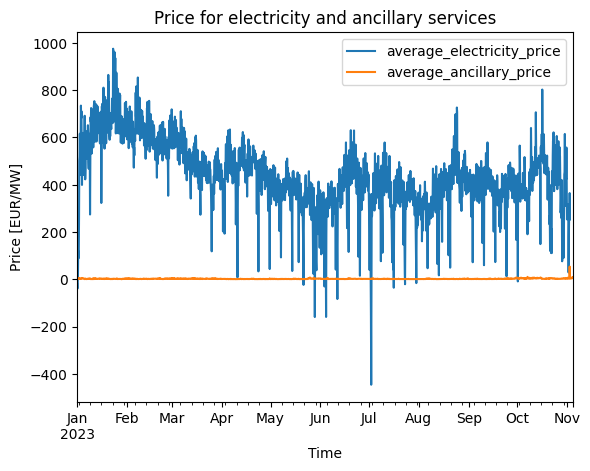

In [16]:
electricity_df["average_electricity_price_scaled"] = electricity_df["average_electricity_price"]
ax = electricity_df.plot(x = "time_start", y = "average_electricity_price", title = "Price for electricity and ancillary services")
ancillary_df.plot(ax = ax, x = "time_start", y = "average_ancillary_price")
ax.set_xlabel("Time")
ax.set_ylabel("Price [EUR/MW]")

In [12]:
date = datetime(year = 2023, day = 5, month=7)

def decision_maker(date, volume, ancillary_df,electricity_df, mode):
    '''mode: string. opt or avg.
        datetime: start time. must be in datetime format
        volume: float
        ancillary_df, electricity_df: dataframe formatted as the corresponding dataframes above
    '''

    if len(ancillary_df[ancillary_df["time_start"] == date]) == 0:
        print(ancillary_df["time_start"].values)
        print("start time invalid:", date)
        return
    
    ancillary_df = ancillary_df[ancillary_df["time_start"] == date]
    electricity_df = electricity_df[electricity_df["time_start"]== date]

    average_electricity_price = electricity_df["average_electricity_price"].values[0]
    average_ancillary_price = ancillary_df["average_ancillary_price"].values[0] 
    current_income = average_ancillary_price*volume
    if mode == "avg":
        if average_ancillary_price > average_electricity_price:
            print("Most profitable: ancillary service")
        elif average_electricity_price > average_ancillary_price:
            print("Most profitable: electricity production")
        else: 
            print("Equally profitable")
        print("Income ancillary service:",volume*average_ancillary_price)
        print("Income electricity production:", volume*average_electricity_price)
        print("Income difference:", abs(volume*(average_ancillary_price-average_electricity_price)) )
    if mode == "opt":
        if average_electricity_price == ancillary_df["average_ancillary_price"].max():
            if ancillary_df[ancillary_df["average_ancillary_price"] == ancillary_df["average_ancillary_price"].max()]["Angebotenes Volumen"].sum() >= volume:
                print("Equally profitable")
            else:
                print("Most profitable: electricity production")
        if average_electricity_price > ancillary_df["average_ancillary_price"].max():
            print("Most profitable: electricity production")
        else:
            volume_left = volume
            current_income = 0
            current_ancillary_df = ancillary_df.sort_values(by = "Leistungspreis",ascending = False)
            current_ancillary_row= ancillary_df.head(1)
            while volume_left > 0 and len(current_ancillary_df) > 0:
                current_volume = min(volume_left,current_ancillary_row["Angebotenes Volumen"])
                volume_left -= current_volume
                current_income += current_volume*current_ancillary_row["Leistungspreis"]
                current_ancillary_df = current_ancillary_df.tail(-1)
            if current_income == volume*average_electricity_price:
                print("Equally profitable")
            if current_income > volume*average_electricity_price:
                print("Most profitable: ancillary service")
            if current_income < volume*average_electricity_price:
                print("Most proftiable: electricity production")
        print("Income ancillary service:",current_income)
        print("Income electricity production:", volume*average_electricity_price)
        print("Income difference:", abs(volume*average_electricity_price-current_income) )


In [13]:
decision_maker(date,5,ancillary_df,electricity_df,mode = "opt")

Most profitable: electricity production
Income ancillary service: 7.274519846350832
Income electricity production: 1844.95
Income difference: 1837.6754801536492


In [14]:
# Single (existing example) plant
#maximal capacity and minimal capacity
# reservoar: assume full once and must be used up until the end of the year
    #Use graph as reference
# run of river: infinite reservoar
# run for every day
# graph of capacity of electricity production/ancillary service